### • Median Consensus

Suppose the sensor network now aims to compute the **median** of the measurement data.

- Implement the **median consensus problem** using the **PDMM algorithm**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from matplotlib.animation import PillowWriter
from IPython.display import Image
from helper import min_radius_for_sensors, generate_random_geometric_graph, graph_is_connected
from pdmm_median_consensus import median_consensus

In [ ]:
# Parameters
NUM_SENSORS = 99
AREA_WIDTH = 100  # meters
DIMENSION = 2

# Ensure all sensors are connected with the desired radius
radius = min_radius_for_sensors(NUM_SENSORS, DIMENSION, AREA_WIDTH) 

# Create graph
coords, adjacency = generate_random_geometric_graph(NUM_SENSORS, radius, AREA_WIDTH)

# coords has shape (N, 2)
random_column = np.random.uniform(low=10, high=30, size=(coords.shape[0], 1))  # shape (N, 1)

# concatenate along axis=1 (columns)
coords_augmented = np.hstack((coords, random_column))  # shape (N, DIMENSION + 1)

# Create figure
plt.figure(figsize=(7, 7))

# Scatter plot with color based on random data
sc = plt.scatter(x = coords[:,0], y = coords[:,1], c=coords_augmented[:,2].flatten(), cmap='jet', label='Sensors')

# Draw dashed black lines for connected sensors
for i in range(NUM_SENSORS):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:  # Avoid duplicates
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     'k--', alpha=0.1)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Random Data Value')

# Check if the graph is connected
is_connected = graph_is_connected(adjacency)
if is_connected:
    print("The graph is connected.")
else:
    print("The graph is NOT connected.")

# Final plot settings
plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Sensor Network with Connections (radius = {radius} m)')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#Run median consensus algorithm
k, median_value, history, tx, errors = median_consensus(
    adjacency,
    coords_augmented[:, 2],
    num_iters = 10000,
    c = 0.32,
    verbose = False,
    Broadcast = True,
    transmission_loss = 0,
    min_error = 1e-12,
    synchronous = True
)



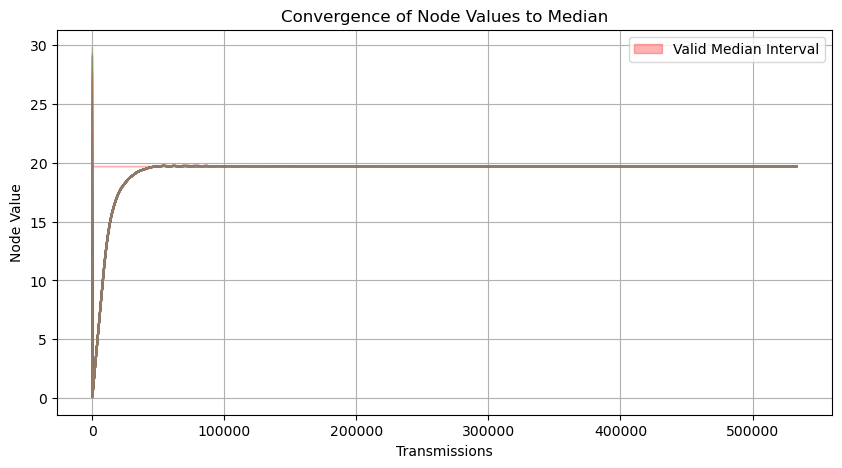

Converged in 533511 transmissions with final normalized error: 0.00000000000027


In [4]:
# Plot convergence of values
plt.figure(figsize=(10, 5))
plt.plot(tx, history, label='_nolegend_', alpha=0.1)
# Add a horizontal shaded region for the median interval
plt.fill_between(tx, median_value[0], median_value[1], color='red',  alpha=0.3, label='Valid Median Interval')
plt.title('Convergence of Node Values to Median')
plt.xlabel('Transmissions')
plt.ylabel('Node Value')
plt.grid()
plt.legend()
plt.show()

#print the final error:
# final_error = np.max(np.abs(history[-1] - median_value))
# final_normalized_error = np.linalg.norm(history[-1] - np.mean(median_value)) / np.linalg.norm(median_value.average())
print(f"Converged in {tx[-1]} transmissions with final normalized error: {errors[-1]:.14f}")



# C optimization takes a long time, and is thus commented during running:

In [ ]:
# AREA_WIDTH = 100  # meters
# DIMENSION = 2
# NUM_SENSORS = 99
# NUM_ITERATIONS = 10000
# ERROR_TOL = 1e-10

# transmissions = []
# # optimize c value for the median consensus algorithm
# c = np.linspace(0.01, 1, 20)

# # Determine connection radius
# radius = min_radius_for_sensors(NUM_SENSORS, DIMENSION, AREA_WIDTH)

# # Generate random geometric graph
# coords, adjacency = generate_random_geometric_graph(NUM_SENSORS, radius, AREA_WIDTH)

# # Add random scalar values (e.g., temperature)
# random_column = np.random.uniform(low=10, high=30, size=(coords.shape[0], 1))
# coords_augmented = np.hstack((coords, random_column))

# for c_value in tqdm(c):
    

#     # Run median consensus
#     _, _, _, tx, _ = median_consensus(
#         adjacency,
#         coords_augmented[:, 2],
#         num_iters=NUM_ITERATIONS,
#         c=c_value,
#         verbose=False,
#         Broadcast=True,
#         transmission_loss=0.0,
#         min_error=ERROR_TOL
#     )
#     transmissions.append(tx[-1])

# # Save the reusults in a file
# np.savez('data/c_optimization_results.npz', c=c, transmissions=transmissions)


In [ ]:
# Open the saved file
data = np.load('data/c_optimization_results.npz')

c = data['c']
transmissions = data['transmissions']

# Create plot with PDMM: Transmissions vs Step Size
plt.figure()
plt.plot(c, transmissions)
plt.xlabel('Step Size (c)',fontsize=14)
plt.ylabel('Number of Transmissions',fontsize=14)
plt.title('Median Consensus PDMM: Transmissions vs Step Size',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/median_consensus_transmissions_vs_step_size.pdf', dpi=600)
plt.show()

# print the c value that gives the least number of transmissions
min_transmissions = min(transmissions)
optimal_c = c[np.argmin(transmissions)]
print(f'Minimum transmissions: {min_transmissions} for c = {optimal_c}')

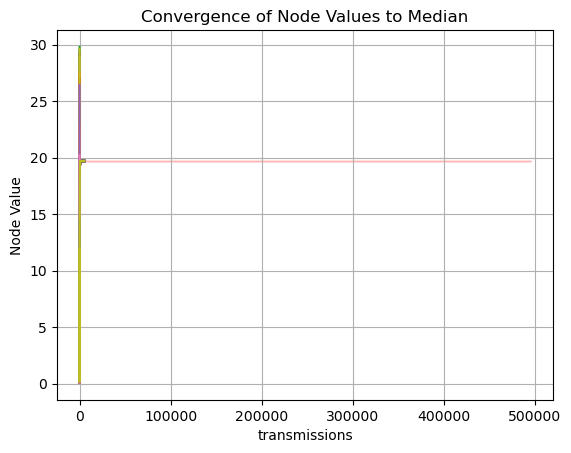

In [6]:
optimal_c = 0.374  # Use the optimal c value found from the previous step

# Run median consensus algorithm
_, median_value, history, tx, errors = median_consensus(adjacency, coords_augmented[:, 2], num_iters=5000, c=optimal_c, verbose=False, 
                                                Broadcast=True, transmission_loss=0.0, min_error=1e-14)

# Plot convergence of values
plt.figure()
plt.fill_between(tx, median_value[0], median_value[1], color='red',  alpha=0.3, label='Valid Median Interval')
plt.plot(history, label='_nolegend_')
plt.title('Convergence of Node Values to Median')
plt.xlabel('transmissions')
plt.ylabel('Node Value')
plt.grid()
plt.show()



In [7]:
# Now plot broadcasting pdmm and unicasting pdmm to compare
plt.figure()


k, real_median, pdmm_history, transmissions, broadcast_errors = median_consensus(adjacency, coords_augmented[:, 2], num_iters=10000, c=optimal_c, verbose=False,
                                            Broadcast=True, transmission_loss=0, min_error=1e-12, synchronous=True)

# Plot the error vs transmissions for the current transmission loss

plt.semilogy(transmissions[1:], broadcast_errors, label=f'PDMM - Broadcast')

k, real_median, pdmm_history, transmissions, unicast_errors = median_consensus(adjacency, coords_augmented[:, 2], num_iters=10000, c=optimal_c, verbose=False,
                                            Broadcast=False, transmission_loss=0, min_error=1e-12, synchronous=True)

# Plot the error vs transmissions for the current transmission loss

plt.semilogy(transmissions[1:], unicast_errors, label=f'PDMM - Unicast')

plt.axhline(1e-12, color='black', linestyle='--', label='Convergence Threshold (1e-12)', linewidth=1)
plt.xlabel('Number of Transmissions', fontsize = 14)
plt.ylabel('Normalized Error (||x - avg|| / ||avg||)', fontsize = 14)
plt.title(f'Median Consensus: Convergence vs Communication cost', fontsize = 14)
plt.grid(True, which='both', ls='--')
plt.legend()
plt.savefig('figures/median_consensus_convergence_vs_communication_cost.pdf', bbox_inches='tight', dpi=600)
plt.show()


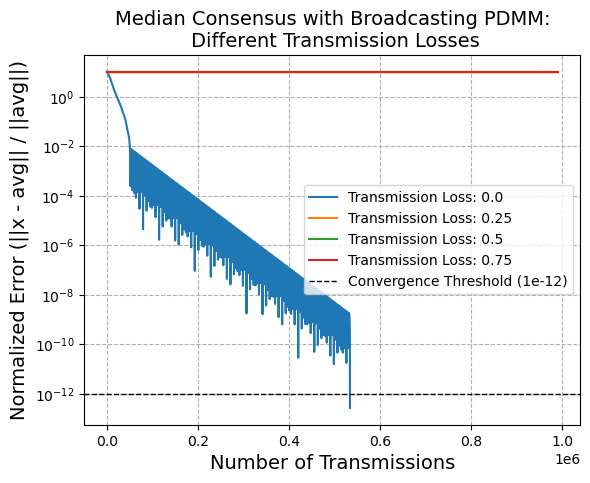

In [8]:
# Now plot broadcasting pdmm with different transmission losses
transmission_losses = [0.0, 0.25, 0.5, 0.75]
plt.figure()

for loss in transmission_losses:
    _, _, _, transmissions_losses, errors = median_consensus(adjacency, coords_augmented[:, 2], num_iters=10000, c=optimal_c, verbose=False,
                                                Broadcast=True, transmission_loss=loss, min_error=1e-12, synchronous=True)
    
      
    # Plot the error vs transmissions for the current transmission loss
    
    plt.semilogy(transmissions_losses[1:], errors, label=f'Transmission Loss: {loss}')

plt.axhline(1e-12, color='black', linestyle='--', label='Convergence Threshold (1e-12)', linewidth=1)
plt.xlabel('Number of Transmissions', fontsize = 14)
plt.ylabel('Normalized Error (||x - avg|| / ||avg||)', fontsize = 14)
plt.title(f'Median Consensus with Broadcasting PDMM:\n Different Transmission Losses', fontsize=14)
plt.grid(True, which='both', ls='--')
plt.legend()
plt.savefig('figures/median_consensus_broadcast_different_transmission_losses.pdf', bbox_inches='tight', dpi=600)
plt.show()

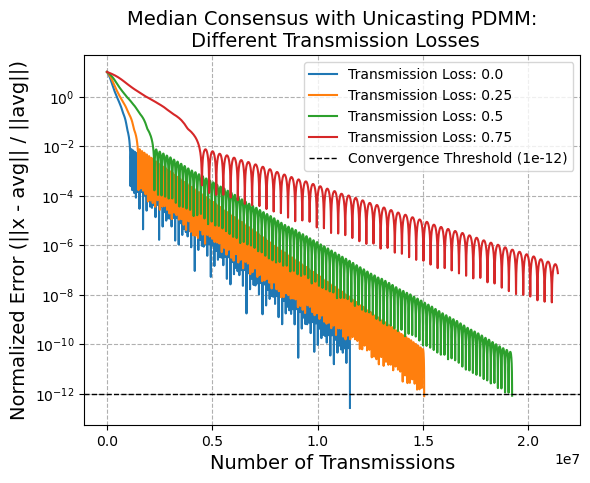

In [ ]:
# Now plot broadcasting pdmm with different transmission losses
transmission_losses = [0.0, 0.25, 0.5, 0.75]
plt.figure()

for loss in transmission_losses:
    _, _, _, transmissions_losses, errors = median_consensus(adjacency, coords_augmented[:, 2], num_iters=10000, c=optimal_c, verbose=False,
                                                Broadcast=False, transmission_loss=loss, min_error=1e-12, synchronous=True)
    
      
    # Plot the error vs transmissions for the current transmission loss
    
    plt.semilogy(transmissions_losses[1:], errors, label=f'Transmission Loss: {loss}')

plt.axhline(1e-12, color='black', linestyle='--', label='Convergence Threshold (1e-12)', linewidth=1)
plt.xlabel('Number of Transmissions', fontsize = 14)
plt.ylabel('Normalized Error (||x - avg|| / ||avg||)', fontsize = 14)
plt.title(f'Median Consensus with Unicasting PDMM:\n Different Transmission Losses', fontsize=14)
plt.grid(True, which='both', ls='--')
plt.legend()
plt.savefig('figures/median_consensus_unicast_different_transmission_losses.pdf', bbox_inches='tight', dpi=600)
plt.show()

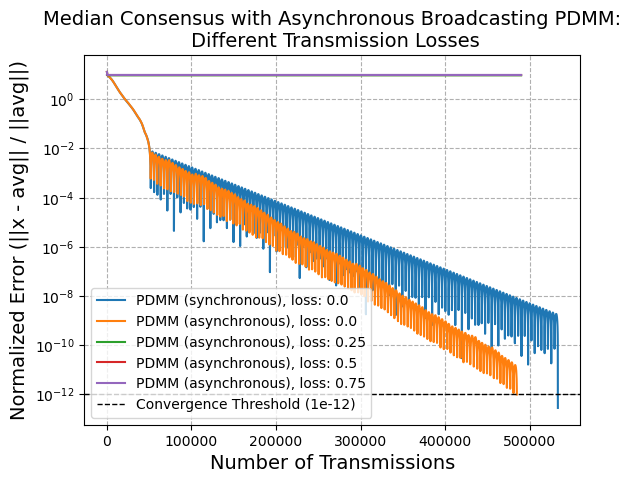

In [10]:

transmission_losses = [0.0, 0.25, 0.5, 0.75]
plt.figure()

_, _, _, transmissions_losses, errors = median_consensus(adjacency, coords_augmented[:, 2], num_iters=10000, c=optimal_c, verbose=False,
                                                Broadcast=True, transmission_loss=0, min_error=1e-12, synchronous=True)


plt.semilogy(transmissions_losses[1:], errors, label=f'PDMM (synchronous), loss: 0.0')

for loss in transmission_losses:
    _, _, _, transmissions_losses, errors = median_consensus(adjacency, coords_augmented[:, 2], num_iters=10000, c=optimal_c, verbose=False,
                                                Broadcast=True, transmission_loss=loss, min_error=1e-12, synchronous=False)
    
    plt.semilogy(transmissions_losses[1:], errors, label=f'PDMM (asynchronous), loss: {loss}')

plt.axhline(1e-12, color='black', linestyle='--', label='Convergence Threshold (1e-12)', linewidth=1)
plt.xlabel('Number of Transmissions', fontsize=14)
plt.ylabel('Normalized Error (||x - avg|| / ||avg||)', fontsize=14)
plt.title(f'Median Consensus with Asynchronous Broadcasting PDMM:\n Different Transmission Losses', fontsize=14)
plt.grid(True, which='both', ls='--')
plt.legend()
plt.savefig('figures/median_consensus_with_PDMM_asynchronous_broadcast_different_transmission_losses.pdf', bbox_inches='tight', dpi=600)
plt.show()

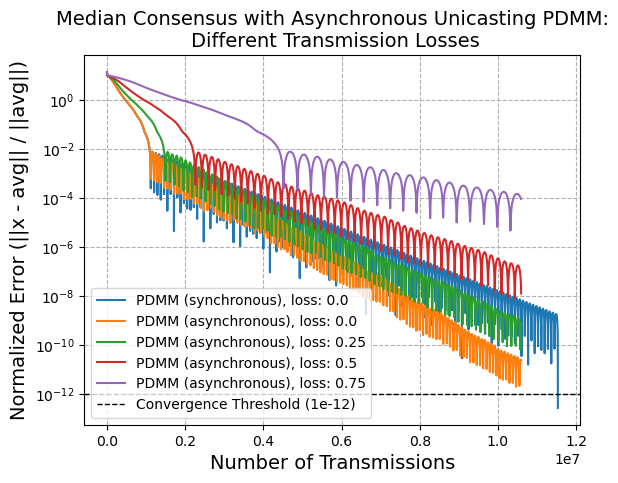

In [11]:

transmission_losses = [0.0, 0.25, 0.5, 0.75]
plt.figure()

_, _, _, transmissions_losses, errors = median_consensus(adjacency, coords_augmented[:, 2], num_iters=10000, c=optimal_c, verbose=False,
                                                Broadcast=False, transmission_loss=0, min_error=1e-12, synchronous=True)


plt.semilogy(transmissions_losses[1:], errors, label=f'PDMM (synchronous), loss: 0.0')

for loss in transmission_losses:
    _, _, _, transmissions_losses, errors = median_consensus(adjacency, coords_augmented[:, 2], num_iters=10000, c=optimal_c, verbose=False,
                                                Broadcast=False, transmission_loss=loss, min_error=1e-12, synchronous=False)
    
    plt.semilogy(transmissions_losses[1:], errors, label=f'PDMM (asynchronous), loss: {loss}')

plt.axhline(1e-12, color='black', linestyle='--', label='Convergence Threshold (1e-12)', linewidth=1)
plt.xlabel('Number of Transmissions', fontsize=14)
plt.ylabel('Normalized Error (||x - avg|| / ||avg||)', fontsize=14)
plt.title(f'Median Consensus with Asynchronous Unicasting PDMM:\n Different Transmission Losses', fontsize=14)
plt.grid(True, which='both', ls='--')
plt.legend()
plt.savefig('figures/median_consensus_with_PDMM_asynchronous_unicast_different_transmission_losses.pdf', bbox_inches='tight', dpi=600)
plt.show()